# DANN testing
load the trained DANN for data assimilation   
for prediction results obtained using ConvLSTM model  
* **observation:** satellite data 
* try with MOD08 daily AOD data
* train on 2018 prediciton (2day ahead forecasting)   
* CAMS initial condition  

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras

import sys
sys.path.append("../utils")
from importlib import reload
import functions, functions_da, my_model_define, functions_utils, forecasting_metrics
reload(functions)
reload(functions_da)
reload(my_model_define)
reload(functions_utils)
reload(forecasting_metrics)

from functions_da import sample_generator_da_global_satellite_diff_5days_iAOD
from my_model_define import DANet
from functions_utils import eac4_loc_load
from forecasting_metrics import evaluate

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-03-17 00:00:14.441185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 00:00:14.995401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-17 00:00:14.995450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-17 00:00:14.995455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# train a ConvLSTM model for Data Assimilation
**3 source data:**  
    1. reanalysis data .nc  
    2. predicted data .npy  
    3. satellite data

In [9]:
# path for files
## for necessary parameters
inpath_refer = '/DATA/EAC4/EAC4_pm2p5_aod550_hourly/eac4-{}.npy'
inpath_pred = '/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy'
inpath_satellite = "/DATA/NASA/MOYD08-combined/satellite-{}.npy"
path_norm = "/DATA/NASA/dic_norm_satellite_justed.json"

# DA model to evaluate
model_name = "../model/DANet_best.h5"

features = {'aod550':1}  # data assimilation for AOD only
n_ch = len(features) + 1  # for satellite-AOD 

# load lon and lat information
lon_mesh, lat_mesh = eac4_loc_load()
nx, ny = lon_mesh.shape
print(nx, ny)

# parameters for normalized (save in a dictionary)
with open(path_norm, 'r') as json_file:
    dic_norm = json.load(json_file)
print(dic_norm)

241 480
{'pm2p5': [0.0, 1e-07], 'aod550': [0.0, 1.0], 'satellite': [0.0, 1.0], 'pm2p5_diff': [0.0, 5e-08], 'aod550_diff': [0.0, 0.4]}


In [10]:
# define and laad the trained model

input_shape = (None, nx,ny,n_ch)
num_out = 1
model_da = convlstm_3(input_shape, 1)

# mse = keras.losses.MeanSquaredError()
def custom_loss(y_actual,y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_actual))
    return mse*1e7
# Register custom loss function
custom_objects = {'custom_loss': custom_loss}

model_da = keras.models.load_model(model_name, custom_objects=custom_objects)

model_da.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 241, 480,   0         
                             2)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 241, 480, 6  422656    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 241, 480, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 241, 480, 6  295168    
                             4)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 241, 480, 6  256  

### testing DANN model on 5-days ahead forecasting

In [11]:
outpath_da = "/DATA/dann_test_2018_tempo/da-{}.npy"

# 5-day ahead forecasting
start_date = datetime(2019, 1, 1, 0)
end_date = datetime(2019, 1, 6, 0)

file_list_test = []
current_date = start_date
while current_date <= end_date:
    filename = inpath_pred.format(start_date.strftime('%Y%m%d%H'), current_date.strftime('%Y%m%d%H'))
    file_list_test.append(filename)
    current_date += timedelta(hours=3)
    
batch_size=1
testGen = sample_generator_da_global_satellite_diff_5days_iAOD(inpath_pred, inpath_satellite, inpath_refer, file_list_test, batch_size, nx, ny, dic_norm, n_feature=n_ch)

nt = testGen.__len__()
print('nt:', nt)

predY = np.empty((nx,ny)) # before da
daY = np.empty((nx,ny))   # after da

for i in range(nt):
    filename = file_list_test[i]

    pattern = r'(\d{8}\d{2})\.npy'
    # Use re.search to find the first match in the string
    match = re.search(pattern, filename)
    if match:
        current_str = match.group(1)
        current = datetime.strptime(current_str, '%Y%m%d%H')
    else:
        print("Datetime not found in the input string.")

    data_test = testGen.__getitem__(i)
    
    testX = data_test[0]
    daY = np.squeeze(model_da.predict(testX, verbose=0))
    predY = np.squeeze(testX[0,0,...,0])  # errorneous prediction

    predY_update = predY.copy()        
    
    # update
    max_o = dic_norm['aod550'][1]
    max_d = dic_norm['aod550_diff'][1]
    predY_update = predY_update*max_o+daY*max_d
    
    filename = outpath_da.format(current_str)
    print(filename)
    # np.save(filename, predY_update)

nt: 41


2024-03-16 23:51:16.330704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-03-16 23:51:16.809414: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 23:51:17.417740: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


/DATA/dann_test_2018_tempo/da-2019010100.npy
/DATA/dann_test_2018_tempo/da-2019010103.npy
/DATA/dann_test_2018_tempo/da-2019010106.npy
/DATA/dann_test_2018_tempo/da-2019010109.npy
/DATA/dann_test_2018_tempo/da-2019010112.npy
/DATA/dann_test_2018_tempo/da-2019010115.npy
/DATA/dann_test_2018_tempo/da-2019010118.npy
/DATA/dann_test_2018_tempo/da-2019010121.npy
/DATA/dann_test_2018_tempo/da-2019010200.npy
/DATA/dann_test_2018_tempo/da-2019010203.npy
/DATA/dann_test_2018_tempo/da-2019010206.npy
/DATA/dann_test_2018_tempo/da-2019010209.npy
/DATA/dann_test_2018_tempo/da-2019010212.npy
/DATA/dann_test_2018_tempo/da-2019010215.npy
/DATA/dann_test_2018_tempo/da-2019010218.npy
/DATA/dann_test_2018_tempo/da-2019010221.npy
/DATA/dann_test_2018_tempo/da-2019010300.npy
/DATA/dann_test_2018_tempo/da-2019010303.npy
/DATA/dann_test_2018_tempo/da-2019010306.npy
/DATA/dann_test_2018_tempo/da-2019010309.npy
/DATA/dann_test_2018_tempo/da-2019010312.npy
/DATA/dann_test_2018_tempo/da-2019010315.npy
/DATA/dann

KeyboardInterrupt: 

In [12]:
# evaluate

inpath_refer = '/DATA/EAC4/EAC4_pm2p5_aod550_hourly/eac4-{}.npy'
inpath_pred = '/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy'
inpath_satellite = "/DATA/NASA/MOYD08-combined/satellite-{}.npy"
inpath_da = "/DATA/dann_test_2018_tempo/da-{}.npy"

index = 1 # 0 for PM2.5; 1 for AOD550

# ------------------ evaluation: metrics ------------------------
RMSE_pred = []
R2_pred = []
RMSE_obs = []
R2_obs = []
RMSE_da = []
R2_da = []

start_date = datetime(2019, 1, 1, 0)
end_date = datetime(2019, 1, 6, 0)
current_date = start_date
while current_date <= end_date:
    filename = inpath_refer.format(current_date.strftime('%Y%m%d%H'))
    refer = np.load(filename)[...,5]
    
    filename = inpath_pred.format(start_date.strftime('%Y%m%d%H'), current_date.strftime('%Y%m%d%H'))
    pred = np.load(filename)[...,-1]
    
    filename = inpath_satellite.format(current_date.strftime('%Y%m%d%H'))
    obs = np.load(filename)
    obs = np.roll(obs, 240, axis=1)
    mask = ~np.isnan(obs)
    
    filename = inpath_da.format(current_date.strftime('%Y%m%d%H'))
    da = np.load(filename)
    
    metrics = evaluate(refer[mask], pred[mask], metrics=('rmse', 'cc'))
    RMSE_pred.append(metrics['rmse'])
    R2_pred.append(metrics['cc']**2)
    
    metrics = evaluate(refer[mask], obs[mask], metrics=('rmse', 'cc'))
    RMSE_obs.append(metrics['rmse'])
    R2_obs.append(metrics['cc']**2)
    
    metrics = evaluate(refer[mask], da[mask], metrics=('rmse', 'cc'))
    RMSE_da.append(metrics['rmse'])
    R2_da.append(metrics['cc']**2)
    
    current_date += timedelta(hours=3)

ValueError: NumPy boolean array indexing assignment cannot assign 134 input values to the 241 output values where the mask is true

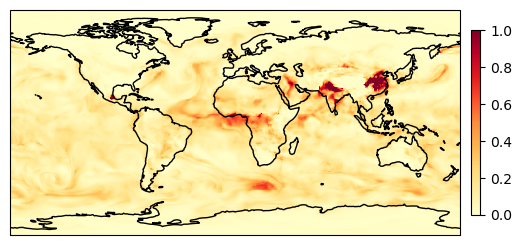

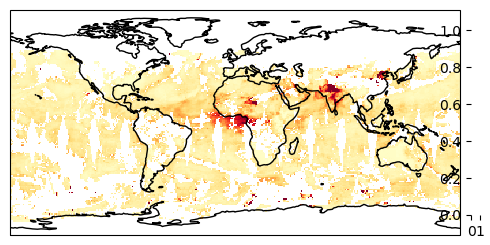

In [14]:
from function_modis import fig_with_map
fig_with_map(lon_mesh, lat_mesh, refer)
fig_with_map(lon_mesh, lat_mesh, obs)


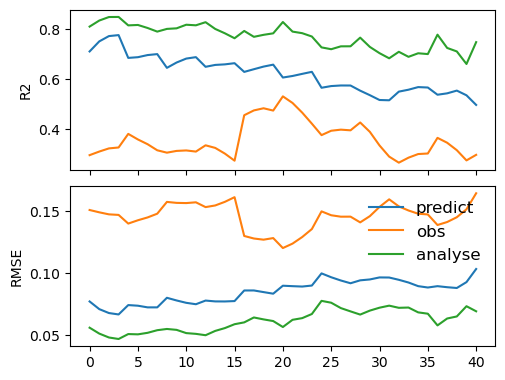

In [15]:
# times_plot
# 48 hours - ahead
ifontsize = 12
fig_width_mm = 120  # specify the width in millimeters
fig_height_mm = 95  # specify the height in millimeters
# Convert millimeters to inches (1 inch = 25.4 mm)
fig_width_inches = fig_width_mm / 25.4
fig_height_inches = fig_height_mm / 25.4

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_width_inches,fig_height_inches), sharex=True)

m = ax[0].plot(R2_pred, label='predict')
m = ax[0].plot(R2_obs, label='obs')
m = ax[0].plot(R2_da, label='analyse')
ax[0].set_ylabel('R2')

m = ax[1].plot(np.array(RMSE_pred), label='predict')
m = ax[1].plot(np.array(RMSE_obs), label='obs')
m = ax[1].plot(np.array(RMSE_da), label='analyse')
ax[1].set_ylabel('RMSE')
ax[1].legend(loc=1, frameon=False, fontsize=ifontsize)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)
fig_path = "/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures/DANN_metrcis_temp_PM2p5.png"
# plt.savefig(fig_path)

plt.show()
# 
# # Calculate mean and variance
# mean_rmse = np.mean(np.array(RMSE0))
# variance_rmse = np.var(np.array(RMSE0))
# 
# print(mean_rmse, variance_rmse)
# 
# print("R > {}, MAE < {}, RMSE < {}".format(min(R), max(MAE), max(RMSE)))

### testing DANN model on 12-hour ahead forecasting (where we conduct DA)

In [22]:
outpath_da = "/DATA/dann_test_2018_tempo/da-{}.npy"

# 12-hour ahead forecasting (all) 
start_date = datetime(2019, 1, 1, 0)
end_date = datetime(2019, 5, 26, 0)

file_list_test = []
current_date = start_date
while current_date <= end_date:
    # 12-hour ahead forecasting for all start time 0, 12
    filename = inpath_pred.format(current_date.strftime('%Y%m%d%H'), (current_date+timedelta(hours=12)).strftime('%Y%m%d%H'))
    file_list_test.append(filename)
    current_date += timedelta(hours=12)

batch_size=1
testGen = sample_generator_da_global_satellite_diff_5days_iAOD(inpath_pred, inpath_satellite, inpath_refer, file_list_test, batch_size, nx, ny, dic_norm, n_feature=n_ch)

nt = testGen.__len__()
print('nt:', nt)

predY = np.empty((nx,ny)) # before da
daY = np.empty((nx,ny))   # after da

for i in range(nt):
    filename = file_list_test[i]

    pattern = r'(\d{8}\d{2})\.npy'
    # Use re.search to find the first match in the string
    match = re.search(pattern, filename)
    if match:
        current_str = match.group(1)
        current = datetime.strptime(current_str, '%Y%m%d%H')
    else:
        print("Datetime not found in the input string.")

    data_test = testGen.__getitem__(i)
    
    testX = data_test[0]
    daY = np.squeeze(model_da.predict(testX, verbose=0))
    predY = np.squeeze(testX[0,0,...,0])  # errorneous prediction

    predY_update = predY.copy()        
    
    # update
    max_o = dic_norm['aod550'][1]
    max_d = dic_norm['aod550_diff'][1]
    predY_update = predY_update*max_o+daY*max_d
    
    filename = outpath_da.format(current_str)
    print(filename)
    np.save(filename, predY_update)

nt: 291
/DATA/dann_test_2018_tempo/da-2019010112.npy
/DATA/dann_test_2018_tempo/da-2019010200.npy
/DATA/dann_test_2018_tempo/da-2019010212.npy
/DATA/dann_test_2018_tempo/da-2019010300.npy
/DATA/dann_test_2018_tempo/da-2019010312.npy
/DATA/dann_test_2018_tempo/da-2019010400.npy
/DATA/dann_test_2018_tempo/da-2019010412.npy
/DATA/dann_test_2018_tempo/da-2019010500.npy
/DATA/dann_test_2018_tempo/da-2019010512.npy
/DATA/dann_test_2018_tempo/da-2019010600.npy
/DATA/dann_test_2018_tempo/da-2019010612.npy
/DATA/dann_test_2018_tempo/da-2019010700.npy
/DATA/dann_test_2018_tempo/da-2019010712.npy
/DATA/dann_test_2018_tempo/da-2019010800.npy
/DATA/dann_test_2018_tempo/da-2019010812.npy
/DATA/dann_test_2018_tempo/da-2019010900.npy
/DATA/dann_test_2018_tempo/da-2019010912.npy
/DATA/dann_test_2018_tempo/da-2019011000.npy
/DATA/dann_test_2018_tempo/da-2019011012.npy
/DATA/dann_test_2018_tempo/da-2019011100.npy
/DATA/dann_test_2018_tempo/da-2019011112.npy
/DATA/dann_test_2018_tempo/da-2019011200.npy
/D

In [24]:
# evaluate

inpath_refer = '/DATA/EAC4/EAC4_pm2p5_aod550_hourly/eac4-{}.npy'
inpath_pred = '/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy'
inpath_satellite = "/DATA/NASA/MOYD08-combined/satellite-{}.npy"
inpath_da = "/DATA/dann_test_2018_tempo/da-{}.npy"

index = 1 # 0 for PM2.5; 1 for AOD550

# ------------------ evaluation: metrics ------------------------
RMSE_pred = []
R2_pred = []
RMSE_obs = []
R2_obs = []
RMSE_da = []
R2_da = []

start_date = datetime(2019, 1, 1, 0)
end_date = datetime(2019, 5, 26, 0)
current_date = start_date
while current_date <= end_date:
    filename = inpath_refer.format((current_date+timedelta(hours=12)).strftime('%Y%m%d%H'))
    refer = np.load(filename)[...,5]
    
    filename = inpath_pred.format(current_date.strftime('%Y%m%d%H'), (current_date+timedelta(hours=12)).strftime('%Y%m%d%H'))
    pred = np.load(filename)[...,1]
    
    filename = inpath_satellite.format((current_date+timedelta(hours=12)).strftime('%Y%m%d%H'))
    obs = np.load(filename)
    obs = np.roll(obs, 240, axis=1)
    mask = ~np.isnan(obs)
    
    filename = inpath_da.format((current_date+timedelta(hours=12)).strftime('%Y%m%d%H'))
    da = np.load(filename)
    
    metrics = evaluate(refer, pred, metrics=('rmse', 'cc'))
    RMSE_pred.append(metrics['rmse'])
    R2_pred.append(metrics['cc']**2)
    
    metrics = evaluate(refer[mask], obs[mask], metrics=('rmse', 'cc'))
    RMSE_obs.append(metrics['rmse'])
    R2_obs.append(metrics['cc']**2)
    
    metrics = evaluate(refer, da, metrics=('rmse', 'cc'))
    RMSE_da.append(metrics['rmse'])
    R2_da.append(metrics['cc']**2)
    
    current_date += timedelta(hours=12)

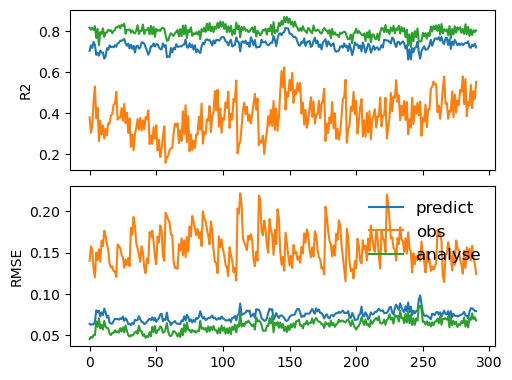

In [25]:
# times_plot
# 48 hours - ahead
ifontsize = 12
fig_width_mm = 120  # specify the width in millimeters
fig_height_mm = 95  # specify the height in millimeters
# Convert millimeters to inches (1 inch = 25.4 mm)
fig_width_inches = fig_width_mm / 25.4
fig_height_inches = fig_height_mm / 25.4

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_width_inches,fig_height_inches), sharex=True)

m = ax[0].plot(R2_pred, label='predict')
m = ax[0].plot(R2_obs, label='obs')
m = ax[0].plot(R2_da, label='analyse')
ax[0].set_ylabel('R2')

m = ax[1].plot(np.array(RMSE_pred), label='predict')
m = ax[1].plot(np.array(RMSE_obs), label='obs')
m = ax[1].plot(np.array(RMSE_da), label='analyse')
ax[1].set_ylabel('RMSE')
ax[1].legend(loc=1, frameon=False, fontsize=ifontsize)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)
fig_path = "/home/sc3020/OneDrive/Paper/Paper4/Nature/submittion2/Figures/DANN_metrcis_temp_PM2p5.png"
# plt.savefig(fig_path)

plt.show()
# 
# # Calculate mean and variance
# mean_rmse = np.mean(np.array(RMSE0))
# variance_rmse = np.var(np.array(RMSE0))
# 
# print(mean_rmse, variance_rmse)
# 
# print("R > {}, MAE < {}, RMSE < {}".format(min(R), max(MAE), max(RMSE)))

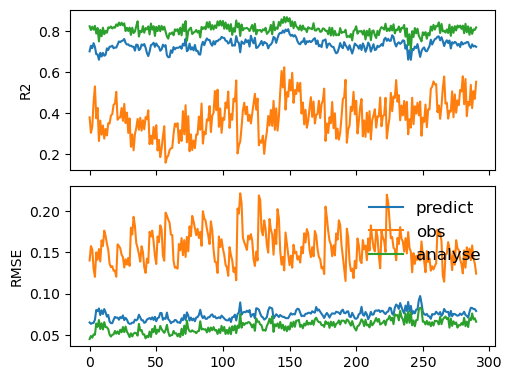

# da test - ave

In [17]:
import random

# use data in 2011-2017 for training and validation
start_date = datetime(2019, 1, 1, 0, 0)
end_date = datetime(2019, 12, 25, 23, 0)
time_interval = timedelta(hours=12)

start_list = []
current_date = start_date
while current_date <= end_date:
    start_list.append(current_date)
    current_date += time_interval

start_list = random.sample(start_list, 100)
n_start = len(start_list)
print(n_start)
# print(start_list)

100


In [18]:
inpath_pred

'/DATA/global-emission-2_11-17_iniCAMS_iAOD/pred/start_{}/pred-{}.npy'

In [19]:
# outpath_da = "/DATA/dann_test_2018_tempo/da-{}.npy"

n_ahead = 41
for start_date in start_list:     
    outpath_da = "/DATA/dann_test_2018_tempo/start_{}/".format(start_date.strftime('%Y%m%d%H'))
    if not os.path.exists(outpath_da):
        os.makedirs(outpath_da)
    
    for ahead in range(n_ahead):
    
        current_date = start_date + timedelta(hours=3*ahead)
        
        filename = inpath_pred.format(start_date.strftime('%Y%m%d%H'), current_date.strftime('%Y%m%d%H'))
        file_list_test = [filename]
        
        batch_size=1
        testGen = sample_generator_da_global_satellite_diff_5days_iAOD(inpath_pred, inpath_satellite, inpath_refer, file_list_test, batch_size, nx, ny, dic_norm, n_feature=n_ch)

        nt = testGen.__len__()

        predY = np.empty((nx,ny)) # before da
        daY = np.empty((nx,ny))   # after da

        data_test = testGen.__getitem__(0)
    
        testX = data_test[0]
        daY = np.squeeze(model_da.predict(testX, verbose=0))
        predY = np.squeeze(testX[0,0,...,0])  # errorneous prediction
    
        predY_update = predY.copy()        
        
        # update
        max_o = dic_norm['aod550'][1]
        max_d = dic_norm['aod550_diff'][1]
        predY_update = predY_update*max_o+daY*max_d
        
        filename = outpath_da + "da-{}.npy".format(current_date.strftime('%Y%m%d%H'))
        print(filename)
        np.save(filename, predY_update)

/DATA/dann_test_2018_tempo/start_2019022412/da-2019022412.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022415.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022418.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022421.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022500.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022503.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022506.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022509.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022512.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022515.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022518.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022521.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022600.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022603.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022606.npy
/DATA/dann_test_2018_tempo/start_2019022412/da-2019022609.npy
/DATA/da